In [24]:
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress CUDA errors
from keras import mixed_precision, utils, layers, losses, optimizers, metrics, callbacks, Sequential
from sklearn import model_selection

mixed_precision.set_global_policy('mixed_float16') # https://keras.io/2/api/mixed_precision/policy/
utils.set_random_seed(42)

In [25]:
data = pl.read_csv('train.csv').drop('date_id').with_columns(
    pl.all().cast(pl.Float64, strict=False),
    pl.col('forward_returns').shift(-1).alias('lagged_forward_returns'),
    pl.col('risk_free_rate').shift(-1).alias('lagged_risk_free_rate'),
    pl.col('market_forward_excess_returns').shift(-1).alias('lagged_market_forward_excess_returns'),
).fill_null(0)
data

D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,…,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns,lagged_forward_returns,lagged_risk_free_rate,lagged_market_forward_excess_returns
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002421,0.000301,-0.003038,-0.008495,0.000303,-0.009114
0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.008495,0.000303,-0.009114,-0.009624,0.000301,-0.010243
0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.009624,0.000301,-0.010243,0.004662,0.000299,0.004046
0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004662,0.000299,0.004046,-0.011686,0.000299,-0.012301
0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011686,0.000299,-0.012301,-0.006449,0.0003,-0.007066
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.565379,0.184524,0.01918,0.01918,0.005952,0.005952,0.911376,-0.083496,-0.572447,0.223638,-0.122314,1.20925,1.540116,1.655174,0.031415,0.33168,0.034722,0.038269,-0.301876,0.914683,0.27414,0.984115,0.080688,0.476521,0.597442,0.718254,0.238757,0.351852,…,0.51455,0.276769,-0.261326,0.811754,1.784929,0.039683,0.249933,0.273148,0.134921,0.634465,-0.446682,-0.052686,0.083995,0.055282,0.209656,0.409392,0.574661,0.748677,0.498677,-0.616395,0.561839,0.53373,-0.432282,0.785053,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.649616,0.002457,0.000155,0.00199,0.002312,0.000156,0.001845
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.562946,0.184193,0.018849,0.018849,0.005622,0.005622,0.911706,-0.083542,-0.57208,0.22291,-0.732397,1.225459,1.537761,1.672262,0.031085,0.331349,0.034392,0.038205,-0.301897,0.915013,0.269841,0.904453,0.073413,0.479167,0.605079,0.718254,0.220899,0.345238,…,0.379299,1.19926,-0.344274,0.690323,1.791596,0.037037,0.298533,0.933201,0.721561,1.211345,-0.11805,-0.249315,0.566799,0.10733,0.228175,0.409392,0.580932,0.37037,0.528439,-0.64204,0.587632,0.526455,-0.429506,0.767857,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,-0.668289,0.002312,0.000156,0.001845,0.002891,0.000156,0.002424
0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.56052,0.183862,0.018519,0.018519,0.005291,0.005291,0.912037,-0.083874,-0.572016,0.222211,-0.800465,1.247273,1.534742,1.695469,0.030754,0.331019,0.034061,0.038118,-0.301918,0.915344,0.273148,0.842295,0.074074,0.478836,0.611319,0.724868,0.223

In [26]:
targets = np.where(data['forward_returns'] > data['risk_free_rate'], 1.0, -1.0)
targets

array([-1., -1., -1., ...,  1.,  1., -1.], shape=(8990,))

In [27]:
inputs = data.drop(['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']).to_numpy()
inputs

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.49467704e-03,  3.02777778e-04, -9.11404562e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.62447844e-03,  3.01190476e-04, -1.02425375e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.66239748e-03,  2.99206349e-04,  4.04620350e-03],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         8.31020684e-03,  1.55952381e-04,  7.84287397e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.88397731e-05,  1.55873016e-04, -3.68167698e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(8990, 97))

In [28]:
N_FEATURES = inputs.shape[-1]
N_FEATURES

97

In [29]:
model = Sequential([
    layers.Input([N_FEATURES]),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(N_FEATURES),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(int(2 * N_FEATURES // 3)),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(1)
], name='v18')

model.compile(loss=losses.CosineSimilarity(), optimizer=optimizers.Adamax(), metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError()])

In [30]:
for k, (i_train, i_val) in enumerate(model_selection.TimeSeriesSplit().split(inputs)):
    model.fit(inputs[i_train], targets[i_train], epochs=1000, validation_data=(inputs[i_val], targets[i_val]), #verbose=0,
              callbacks=[callbacks.EarlyStopping(patience=50, restore_best_weights=True), callbacks.TerminateOnNaN()])
    model.save(f'.models/{model.name}.keras')
    while gc.collect() > 0: pass

Epoch 1/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: -0.0360 - mean_absolute_error: 1.6168 - mean_squared_error: 4.2687 - val_loss: -0.0160 - val_mean_absolute_error: 1.5565 - val_mean_squared_error: 3.6567
Epoch 2/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0133 - mean_absolute_error: 1.7357 - mean_squared_error: 4.7966 - val_loss: 0.0093 - val_mean_absolute_error: 1.5683 - val_mean_squared_error: 3.8288
Epoch 3/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0067 - mean_absolute_error: 1.6561 - mean_squared_error: 4.4507 - val_loss: 0.0227 - val_mean_absolute_error: 1.7430 - val_mean_squared_error: 4.8704
Epoch 4/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0027 - mean_absolute_error: 1.6492 - mean_squared_error: 4.2827 - val_loss: 0.0134 - val_mean_absolute_error: 1.9809 - val_mean_squared_error: 6.5740
Epoch 5/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0027 - mean_absolute_error: 1.5096 - mean_squared_error: 3.6782 - val_loss: 0.0107 

In [31]:
test_data = pl.read_csv('test.csv').drop(['date_id', 'is_scored']).fill_null(0)
test_data

D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,lagged_forward_returns,lagged_risk_free_rate,lagged_market_forward_excess_returns
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0,0,0,1,0,0,1,0,1.577651,0.186177,0.001323,0.001323,0.001323,0.001323,0.955026,-0.583419,-0.704264,0.298365,-0.691361,1.259065,1.556516,1.71258,0.033069,0.333333,0.036376,-0.046483,-0.312326,0.913029,0.306217,1.025756,0.081349,0.478175,0.675627,0.699735,0.256283,0.36045,…,0.794643,-1.427834,0.352513,0.926257,0.431383,-0.476976,0.500245,1.784173,0.029762,0.294719,0.51455,0.446429,0.466551,0.085717,-0.230132,0.272487,-0.106894,0.199735,0.409392,0.532717,0.744048,0.440476,-0.654839,0.699735,0.699074,-0.5024,0.882937,0.892196,0.828042,0.999172,0.759921,-0.803127,0.170966,-0.751909,0.003541,0.000161,0.003068
0,0,0,0,1,0,0,1,0,1.575182,0.185847,0.000992,0.000992,0.000992,0.000992,0.955357,-0.583074,-0.703759,0.297608,-0.504499,1.193468,1.554184,1.640054,0.032738,0.333003,0.036045,0.073582,-0.312345,0.91336,0.305886,0.989571,0.082672,0.477844,0.661527,0.719577,0.255952,0.361111,…,0.71131,-1.37652,0.953042,0.386905,0.523549,-0.421365,-0.234829,1.770175,0.03373,0.304496,0.638228,0.636905,1.849101,0.28169,-0.041995,0.448413,0.094321,0.215608,0.409392,0.597864,0.872354,0.691138,-0.583443,0.62996,0.598545,-0.394268,0.863757,0.699074,0.831349,1.120336,0.556217,-0.686192,0.141865,-0.660326,-0.005964,0.000162,-0.006437
0,0,0,0,1,0,0,0,1,1.57272,0.185516,0.000661,0.000661,0.000661,0.000661,0.955688,-0.083356,-0.573546,0.225822,-0.393903,1.123361,1.551723,1.562722,0.032407,0.332672,0.035714,0.033581,-0.312364,0.91369,0.291997,1.040514,0.081349,0.477513,0.655741,0.724206,0.22619,0.35582,…,0.212632,-1.34762,0.210979,0.635251,-1.138198,-0.494248,-1.042718,1.754171,0.032407,0.257609,0.082011,0.152116,-0.201611,0.346373,0.054032,0.137566,0.294305,0.194444,0.409392,0.596528,0.778439,0.634921,-0.483236,0.669974,0.603836,-0.17042,0.848545,0.647487,0.832672,1.088992,0.665344,-0.459367,0.199405,-0.510979,-0.00741,0.00016,-0.007882
0,0,0,0,1,0,0,0,1,1.570266,0.185185,0.019841,0.019841,0.006614,0.006614,0.956019,-0.083403,-0.57318,0.225094,-0.541646,1.167982,1.549272,1.611215,0.032077,0.332341,0.035384,0.033998,-0.312383,0.914021,0.267196,1.091376,0.085979,0.477183,0.648582,0.728175,0.230159,0.351852,…,0.660714,-1.399411,0.724868,0.21627,-0.230557,-0.318347,0.396917,1.769678,0.03373,0.20235,0.324074,0.212963,0.052878,-0.049023,0.120828,0.219577,0.137942,0.167328,0.409392,0.579726,0.449735,0.665344,-0.546298,0.590608,0.558862,-0.275099,0.826058,0.445767,0.835979,1.040988,0.594577,-0.561643,0.161706,-0.575997,0.00542,0.00016,0.004949
0,0,0,0,0,0,1,0,1,1.567818,0.184854,0.019511,0.019511,0.006283,0.006283,0.956349,-0.083449,-0.572813,0.224366,-0.714549,1.243713,1.542543,1.693604,0.031746,0.332011,0.035053,0.029586,-0.301855,0.914352,0.260913,1.011571,0.093915,0.476852,0.638667,0.729497,0.238757,0.353836,…,0.32672,-1.416282,0.611442,0.426257,0.046472,-0.262086,1.304142,1.785515,0.039683,0.230364,0.583995,0.445106,1.378927,-0.182025,0.01261,0.369048,0.011021,0.130291,0.409392,0.572656,0.489418,0.600529,-0.587258,0.46131,0.487434,-0.39548,0.80754,0.707672,0.839947,0.944593,0.715608,-0.692649,0.124669,-0.654045,0.008357,0.000159,0.007887
0,0,0,0,0,0,0,0,0,1.565379,0.184524,0.01918,0.01918,0.005952,0.005952,0.911376,-0.083496,-0.572447,0.223638,-0.122314,1.20925,1.540116,1.655174,0.031415,0.33168,0.034722,0.038269,-0.301876,0.914683,0.27414,0.984115,0.080688,0.476521,0.597442,0.718254,0.238757,0.351852,…,0.625331,-1.354498,0.046296,0.51455,0.276769,-0.261326,

In [32]:
test_targets = np.where(test_data['lagged_market_forward_excess_returns'].shift(1) > 0, 1.0, -1.0)
test_targets

array([-1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.])

In [33]:
test_inputs = test_data.to_numpy()
test_inputs.shape

(10, 97)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


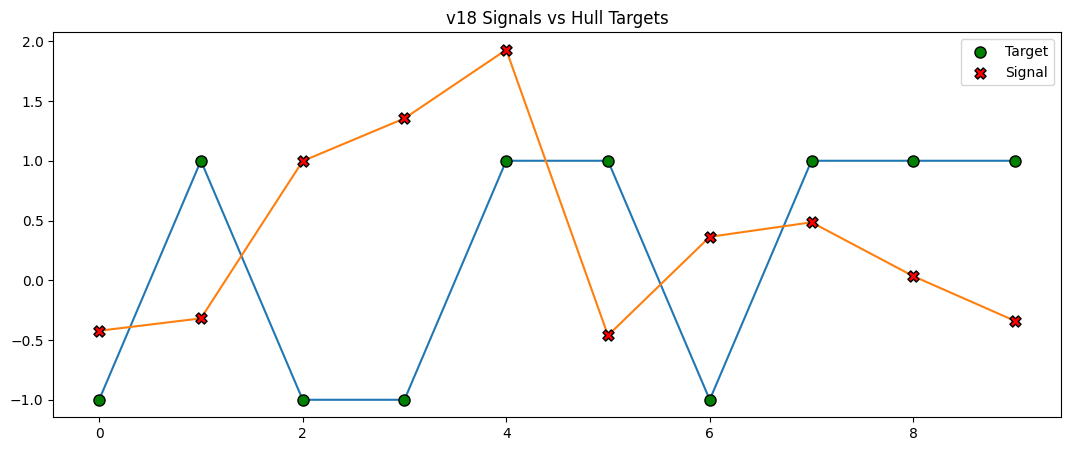

In [40]:
plt.figure(figsize=(13, 5))
plt.title(f'{model.name} Signals vs Hull Targets')
plt.plot(test_targets, zorder=-1)
indices = np.arange(test_targets.shape[0])
plt.scatter(indices, test_targets, label='Target', edgecolors='k', c='g', s=64)
signals = model.predict(test_inputs)
plt.plot(signals, zorder=-1)
plt.scatter(indices, signals, label='Signal', marker='X', edgecolors='k', c='r', s=64)
plt.legend()
pass